In [1]:
! pip install tensorflow-model-optimization wandb

In [2]:
# utils functions

import pathlib
import shutil
import os
import time
import datetime 
import numpy as np
import wandb
import tensorflow as tf
import matplotlib.pyplot as plt
import zipfile

from typing import List

def load_data(run, artifact_name = "phcd_paper_splits_tfds") -> List[tf.data.Dataset]:
    """
    Downloads datasets from a wandb artifact and loads them into a list of tf.data.Datasets.
    """

    artifact = run.use_artifact(f"master-thesis/{artifact_name}:latest")
    artifact_dir = pathlib.Path(
        f"./artifacts/{artifact.name.replace(':', '-')}"
    ).resolve()
    if not artifact_dir.exists():
        artifact_dir = artifact.download()
        artifact_dir = pathlib.Path(artifact_dir).resolve()

    # if tf.__version__ minor is less than 10, use
    # tf.data.experimental.load instead of tf.data.Dataset.load

    if int(tf.__version__.split(".")[1]) < 10:
        load_function = tf.data.experimental.load
    else:
        load_function = tf.data.Dataset.load
    
    output_list = []
    for split in ["train", "test", "val"]:
        ds = load_function(str(artifact_dir / split), compression="GZIP")
        output_list.append(ds)
    
    return output_list

def get_readable_class_labels(subset = 'phcd_paper'):
    if subset == 'phcd_paper':
        return ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c',
        'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p',
        'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C',
        'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P',
        'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'ą', 'ć', 'ę',
        'ł', 'ń', 'ó', 'ś', 'ź', 'ż', 'Ą', 'Ć', 'Ę', 'Ł', 'Ń', 'Ó', 'Ś',
        'Ź', 'Ż', '+', '-', ':', ';', '$', '!', '?', '@', '.']
    elif subset == 'uppercase':
        return ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 
        'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'Ą', 'Ć', 
        'Ę', 'Ł', 'Ń', 'Ó', 'Ś', 'Ź', 'Ż']
    elif subset == 'lowercase':
        return ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
        'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'ą', 'ć',
        'ę', 'ł', 'ń', 'ó', 'ś', 'ź', 'ż']
    elif subset == 'numbers':
        return ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    elif subset == 'uppercase_no_diacritics':
        return ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
        'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
    elif subset == 'lowercase_no_diacritics':
        return ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
        'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

def calculate_accuracy_per_class(model, test_dataset, test_dataset_name):
    '''
    Calculates the accuracy per class for a given model and test dataset.

    Returns dict with class labels as keys and accuracy as values.
    '''
        
    y_pred = model.predict(test_dataset)
    y_pred = np.argmax(y_pred, axis=1)
    # get labels
    y_true = test_dataset.map(lambda x, y: y).as_numpy_iterator()
    y_true = np.concatenate(list(y_true))
    # calculate accuracy per class
    labels = get_readable_class_labels(test_dataset_name)
    class_accuracy = np.zeros(len(labels))
    for i, label in enumerate(labels):
        class_accuracy[i] = np.sum(y_pred[y_true == i] == i) / np.sum(y_true == i)
    return { label: acc for label, acc in zip(labels, class_accuracy) }
    

def plot_accuracy_per_class(class_accuracy_dict):
    plt.figure(figsize=(10, 5))
    labels = list(class_accuracy_dict.keys())
    class_accuracy = list(class_accuracy_dict.values())
    plt.bar(labels, class_accuracy)
    plt.xticks(labels)
    plt.xlabel("Class")
    plt.ylabel("Accuracy")
    plt.title("Accuracy per class")
    plt.show()


def accuracy_table(class_accuracy_dict):
    labels = list(class_accuracy_dict.keys())
    class_accuracy = list(class_accuracy_dict.values())
    return wandb.Table(columns=["Class", "Accuracy"], data=list(zip(labels, class_accuracy)))

def get_number_of_classes(ds: tf.data.Dataset) -> int:
    """
    Returns the number of classes in a dataset.
    """
    labels_iterator= ds.map(lambda x, y: y).as_numpy_iterator()
    labels = np.concatenate(list(labels_iterator))
    return len(np.unique(labels))

def get_number_of_examples(ds: tf.data.Dataset) -> int:
    """
    Returns the number of examples in a dataset.
    """
    return sum(1 for _ in ds)

def preprocess_dataset(ds: tf.data.Dataset, batch_size: int, cache: bool = True) -> tf.data.Dataset:
    ds = ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))  # normalize
    ds = ds.unbatch().batch(batch_size)
    if cache:
        ds = ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

def calculate_model_compressed_size_on_disk(path: str) -> int:
    compressed_path = path + ".zip"
    with zipfile.ZipFile(compressed_path, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(path)
    return pathlib.Path(compressed_path).stat().st_size    

def calculate_model_size_on_disk(path: str) -> int:
    return pathlib.Path(path).stat().st_size

def calculate_model_num_parameters(model: tf.keras.Model) -> int:
    return model.count_params()

def calculate_model_flops(summary) -> float:
    # from run.summary get GFLOPs or GFLOPS whichever is available
    if "GFLOPs" in summary.keys():
        return summary.get("GFLOPs")
    elif "GFLOPS" in summary.keys():
        return summary.get("GFLOPS")
    else:
        return 0
    
def plot_history(history, title):
    plt.figure(figsize=(15,7))
    plt.suptitle(title)
    
    plt.subplot(121)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    
    plt.subplot(122)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()

In [3]:
import wandb
import pandas as pd
import pathlib

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")



project_name = "master-thesis"
run_name = "architecture-1"

def get_runs(project_name, run_name):
    """
    Returns all runs with a given name in a given project.
    """
    api = wandb.Api()
    runs = api.runs(
        project_name, {
            "$and": [
                {"displayName": run_name},
                {"state": "finished"},
                {"tags": "phcd_paper_splits_tfds"}
                ]
            })
    return [run.id for run in runs]

def get_model_from_run(run_id, project_name="master-thesis"):
    # from project run_id artifacts get file_name
    api = wandb.Api()
    run = api.run(f"{project_name}/{run_id}")
    # download file config.yaml
    run.file("config.yaml").download(replace=True)
    artifact = run.file("model_baseline.h5").download(replace=True)
    model = tf.keras.models.load_model(artifact.name, compile=False)
    return model, pathlib.Path(artifact.name)

run_ids = get_runs(project_name, run_name)

In [4]:
defaults = dict(
    batch_size=32*2,
    epochs=60,    
    optimizer="adam"
)

artifact_base_name = "phcd_paper"
artifact_name = f"{artifact_base_name}_splits_tfds" # "phcd_paper_splits_tfds
arch_short_name = "arch-1"
run = wandb.init(project="master-thesis", job_type="model-optimization",  config=defaults, tags=["optimization"])

# hyperparameters
epochs = wandb.config.epochs
bs = wandb.config.batch_size

ds_train, ds_test, ds_val = load_data(run, artifact_name=artifact_name)

num_classes = get_number_of_classes(ds_val)

ds_train_non_normalized = ds_train.unbatch().batch(64).cache().prefetch(buffer_size=tf.data.AUTOTUNE).take(2000)
ds_test_non_normalized = ds_test.unbatch().batch(64).cache().prefetch(buffer_size=tf.data.AUTOTUNE).take(1743)

ds_train = preprocess_dataset(ds_train, batch_size=bs)
ds_val = preprocess_dataset(ds_val, batch_size=bs)
ds_test = preprocess_dataset(ds_test, batch_size=bs, cache=False)
ds_test = ds_test.take(1743)


wandb: Currently logged in as: gratkadlafana. Use `wandb login --relogin` to force relogin


wandb:   9 of 9 files downloaded.  
2023-03-20 19:06:18.572702: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-20 19:06:18.572722: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (wiktor-on-linux): /proc/driver/nvidia/version does not exist
2023-03-20 19:06:18.572864: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# before optimization

In [5]:
def save_dataset_as_tfrecords(ds: tf.data.Dataset, path):
    def serialize_example(image, label):
        image = tf.io.serialize_tensor(image)
        label = tf.io.serialize_tensor(label)
        feature = {
            "image": tf.train.Feature(bytes_list=tf.train.BytesList(value=[image.numpy()])),
            "label": tf.train.Feature(bytes_list=tf.train.BytesList(value=[label.numpy()])),
        }
        example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
        return example_proto.SerializeToString()

    writer = tf.data.experimental.TFRecordWriter(path)
    writer.write(ds.map(serialize_example))

def benchmark(bench_model, bench_model_path, bench_dataset):
    test_loss, test_acc = bench_model.evaluate(bench_dataset)
    num_parameters = calculate_model_num_parameters(bench_model)
    compressed_disk_size = calculate_model_compressed_size_on_disk(bench_model_path)

    print(f"Test accuracy: {test_acc}")
    
    print(f"Number of parameters: {num_parameters}")
    print(f"Compressed disk size (MB): {compressed_disk_size / 1e6}")
    return test_acc, num_parameters, compressed_disk_size

def benchmark_tflite(bench_model, bench_model_path, bench_dataset):
    test_loss, test_acc = bench_model.evaluate(bench_dataset)
    num_parameters = calculate_model_num_parameters(bench_model)
    compressed_disk_size = calculate_model_compressed_size_on_disk(bench_model_path)
    
    print(f"Test loss: {test_loss}")
    print(f"Test accuracy: {test_acc}")
    
    print(f"Number of parameters: {num_parameters}")
    print(f"Compressed disk size (MB): {compressed_disk_size / 1e6}")
    return test_acc, num_parameters, compressed_disk_size

def plot_results(acc, num_params, dsk_size):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    data = [acc, num_params, dsk_size]
    # boxplots
    for i, ax in enumerate(axes.flatten()):
        # draw boxplot with seaborn
        sns.boxplot(data[i], ax=ax)
        # add title
        ax.set_title(f"{['Accuracy', 'Number of parameters', 'Compressed disk size'][i]}")

    # super title
    fig.suptitle("Pruning results - accuracy, # of parameters, compressed disk size", fontsize=16)

# Optimization - pruning & quantization

In [6]:
# for evaluating tflite models
def evaluate_model(interpreter, test_dataset):
    """
    Evaluates the performance of a TensorFlow Lite model on a given test dataset.

    Args:
        interpreter (tf.lite.Interpreter): A TensorFlow Lite interpreter object with already allocated tensors.
        test_dataset (tf.data.Dataset): A TensorFlow dataset object containing test images and labels.

    Returns:
        A tuple (accuracy, loss) with the model accuracy and loss on the test dataset.
    """
    # Prepare the input and output tensors
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    input_shape = input_details[0]['shape']
    input_tensor_index = input_details[0]['index']
    output_tensor_index = output_details[0]['index']

    # Run the evaluation
    total_loss = 0.0
    total_accuracy = 0.0
    num_batches = 0

    for images, labels in tqdm.tqdm(test_dataset, desc="Evaluating model"):
        # Set the input tensor shape to match the batch size
        #input_shape[0] = images.shape[0]

        # Resize the images to match the input tensor shape
        images = tf.image.resize(images, input_shape[1:3])

        # Set the input tensor value
        interpreter.set_tensor(input_tensor_index, images)

        # Run the inference
        interpreter.invoke()

        # Get the output tensor value
        output = interpreter.get_tensor(output_tensor_index)

        # Compute the batch loss and accuracy
        batch_loss = tf.keras.losses.sparse_categorical_crossentropy(labels, output)
        batch_accuracy = tf.keras.metrics.sparse_categorical_accuracy(labels, output)

        # Update the total loss and accuracy
        total_loss += tf.reduce_sum(batch_loss)
        total_accuracy += tf.reduce_sum(batch_accuracy)
        num_batches += 1

    # Compute the average loss and accuracy
    average_loss = total_loss / (num_batches * input_shape[0])
    average_accuracy = total_accuracy / (num_batches * input_shape[0])

    return average_accuracy.numpy() #, average_loss.numpy()

In [7]:
raise Exception("Stop")

Exception: Stop

In [17]:
import tensorflow_model_optimization as tfmot
from tensorflow.keras.optimizers.schedules import PolynomialDecay
import tqdm

results_columns = ["run_id", "optimization_type",  "accuracy", "num_parameters", "compressed_disk_size"]
results = pd.DataFrame(columns=results_columns)
do_pruning = False


for run_id in tqdm.tqdm(run_ids, desc="Runs"):
  print(f"Run id: {run_id}")
  model, model_path = get_model_from_run(run_id, project_name)
  model.compile(
        optimizer="adam",
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
  
  base_acc, base_num_param, base_compressed_disk_size = benchmark(model, str(model_path), ds_test) 
  
  base_results = pd.DataFrame(columns=results_columns, data=[[run_id, "baseline", base_acc, base_num_param, base_compressed_disk_size]])
  results = pd.concat([results, base_results])

  print("Base model accuracy: ", base_acc)


  if do_pruning:
    # pruning
    pruning_epochs = 5
    batch_size = 64
    num_train_samples = sum(1 for _ in ds_train)
    end_step = np.ceil(1.0 * num_train_samples / batch_size).astype(np.int32) * pruning_epochs
    print('End step: ' + str(end_step))

    pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.05, final_sparsity=0.45, begin_step=0, end_step=end_step),
    }
    prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
    
    model_sparse = prune_low_magnitude(model, **pruning_params)
    model_sparse.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
      metrics=['accuracy'],
    )
    sparse_model_filename = f"{run_id}_model_sparse.h5"
    print("Pruning model...")
    history = model_sparse.fit(
        ds_train,
        epochs=pruning_epochs,
        validation_data=ds_val,
        callbacks=[
          tfmot.sparsity.keras.UpdatePruningStep(),
          # checkpoint
          tf.keras.callbacks.ModelCheckpoint(
              filepath=sparse_model_filename,
              save_weights_only=False,
              monitor="val_accuracy",
              mode="max",
              save_best_only=True,
          ),
      ]
    )

    # plot history
    plot_history(history, "Pruning")
    plt.show()
    #tf.keras.models.save_model(model_sparse, 'model_sparse.h5', include_optimizer=False)

    test_acc, num_param, compressed_disk_size = benchmark(model_sparse, sparse_model_filename, ds_test)
    print("Pruned model accuracy: ", test_acc)
    sparse_results = pd.DataFrame(columns=results_columns, data=[[run_id, "pruning", test_acc, num_param, compressed_disk_size]])
    results = pd.concat([results, sparse_results])
    # send model to wandb
    wandb.save(sparse_model_filename)

    del model
    del model_sparse

  
  # quantization
  model, model_path = get_model_from_run(run_id, project_name)
  model.compile(
        optimizer="adam",
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )

  quantization_epochs = 2

  quantize_model = tfmot.quantization.keras.quantize_model
  model_quant = quantize_model(model)
  model_quant.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    metrics=['accuracy'],
  )
  quantization_aware_model_filename = f"{run_id}_model_quant.h5"
  print("Fitting quantization aware model")
  history = model_quant.fit(
      ds_train,
      epochs=quantization_epochs,
      validation_data=ds_val,
  )

  # plot history
  plot_history(history, "Quantization")
  tf.keras.models.save_model(model_quant, quantization_aware_model_filename, include_optimizer=False)

  test_acc, num_param, compressed_disk_size = benchmark(model_quant, quantization_aware_model_filename, ds_test)
  print("Quantization aware model accuracy: ", test_acc)

  quant_aware_results = pd.DataFrame(columns=results_columns, data=[[run_id, "quantization_aware", test_acc, num_param, compressed_disk_size]])
  results = pd.concat([results, quant_aware_results])

  # ------------------ TF Lite ------------------------

  tflite_models_dir = pathlib.Path("./models/")
  tflite_models_dir.mkdir(exist_ok=True, parents=True)

  dynamic_range_model_file = tflite_models_dir / f"{run_id}_{arch_short_name}_dynamic_range.tflite"
  fp16_model_file = tflite_models_dir / f"{run_id}_{arch_short_name}_fp16.tflite"
  int8_model_file = tflite_models_dir / f"{run_id}_{arch_short_name}_int8.tflite"

  def representative_dataset_gen():
    for input_value, _ in ds_train_non_normalized:
      yield [input_value]

  # dynamic range
  converter = tf.lite.TFLiteConverter.from_keras_model(model_quant)
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  model_quant_dynamic_range = converter.convert()
  dynamic_range_model_file.write_bytes(model_quant_dynamic_range)

  # quantization fp16
  converter = tf.lite.TFLiteConverter.from_keras_model(model_quant)
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  converter.target_spec.supported_types = [tf.float16]
  converter.representative_dataset = representative_dataset_gen
  model_quant_fp16 = converter.convert()
  fp16_model_file.write_bytes(model_quant_fp16)

  # quantization int8
  converter = tf.lite.TFLiteConverter.from_keras_model(model_quant)
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  converter.representative_dataset = representative_dataset_gen
  converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
  converter.inference_input_type = tf.float16  # or tf.uint8
  converter.inference_output_type = tf.int8  # or tf.uint8
  model_quant_int8 = converter.convert()
  int8_model_file.write_bytes(model_quant_int8)

  # load dynamic range model
  interpreter = tf.lite.Interpreter(model_path=str(dynamic_range_model_file))
  # set batch size to 64
  interpreter.resize_tensor_input(0, [64, 32, 32, 1])
  interpreter.allocate_tensors()

  print("Evaluating dynamic range model")
  test_acc_dynamic_range = evaluate_model(interpreter, ds_test)
  compressed_disk_size_dynamic_range = calculate_model_compressed_size_on_disk(str(dynamic_range_model_file))
  
  print("Dynamic range accuracy: ", test_acc_dynamic_range)

  dynamic_range_results = pd.DataFrame(columns=results_columns, data=[[run_id, "dynamic_range", test_acc_dynamic_range, 0, compressed_disk_size_dynamic_range]])
  results = pd.concat([results, dynamic_range_results])


  # load fp16 model
  interpreter = tf.lite.Interpreter(model_path=str(fp16_model_file))
  interpreter.resize_tensor_input(0, [64, 32, 32, 1])
  interpreter.allocate_tensors()

  print("Evaluating fp16 model")
  test_acc_fp16 = evaluate_model(interpreter, ds_test)
  
  print("FP16 accuracy: ", test_acc_fp16)
  compressed_disk_size_fp16 = calculate_model_compressed_size_on_disk(str(fp16_model_file))

  fp16_results = pd.DataFrame(columns=results_columns, data=[[run_id, "fp16", test_acc_fp16, 0, compressed_disk_size_fp16]])
  results = pd.concat([results, fp16_results])

  # load int8 model
  interpreter = tf.lite.Interpreter(model_path=str(int8_model_file))
  interpreter.resize_tensor_input(0, [64, 32, 32, 1])
  interpreter.allocate_tensors()

  # evaluate interpreter on ds_test: tf.data.Dataset
  print("Evaluating int8 model")
  test_acc_int8 = evaluate_model(interpreter, ds_test_non_normalized)
  print("Int8 accuracy: ", test_acc_int8)
  compressed_disk_size_int8 = calculate_model_compressed_size_on_disk(str(int8_model_file))

  int8_results = pd.DataFrame(columns=results_columns, data=[[run_id, "int8", test_acc_int8, 0, compressed_disk_size_int8]])
  results = pd.concat([results, int8_results])

results_file = f"optimalization_results_{arch_short_name}.csv"
results.to_csv(results_file)
wandb.save(results_file)

Runs:   0%|          | 0/8 [00:00<?, ?it/s]

Run id: t7x4xuzk
      8/Unknown - 0s 7ms/step - loss: 0.1478 - accuracy: 0.9590  

/home/wiktor/.pyenv/versions/3.10.9/envs/master-thesis/lib/python3.10/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


    684/Unknown - 5s 8ms/step - loss: 0.1857 - accuracy: 0.9606

Runs:   0%|          | 0/8 [00:09<?, ?it/s]


KeyboardInterrupt: 

Fitting quantization aware model
Epoch 1/2


/home/wiktor/.pyenv/versions/3.10.9/envs/master-thesis/lib/python3.10/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


6105/6105 [==============================] - 148s 24ms/step - loss: 0.1684 - accuracy: 0.9541 - val_loss: 0.1096 - val_accuracy: 0.9681
Epoch 2/2
1743/1743 [==============================] - 11s 7ms/step - loss: 0.0805 - accuracy: 0.9743
Test accuracy: 0.9742989540100098
Number of parameters: 1779380
Compressed disk size (MB): 6.707836
Quantization aware model accuracy:  0.9742989540100098


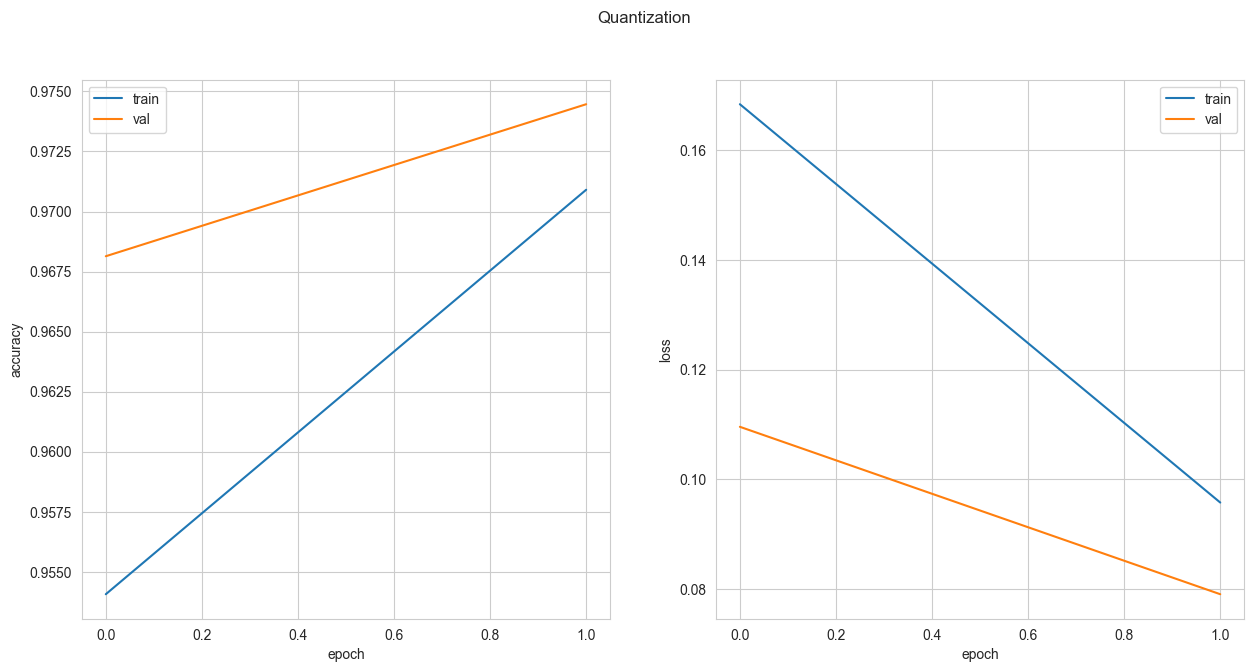

In [21]:
import tensorflow_model_optimization as tfmot
from tensorflow.keras.optimizers.schedules import PolynomialDecay
import tqdm

run_id = "u1ezrh04"
model, model_path = get_model_from_run(run_id, project_name)
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

quantization_epochs = 2

quantize_model = tfmot.quantization.keras.quantize_model
model_quant = quantize_model(model)
model_quant.compile(
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
metrics=['accuracy'],
)
quantization_aware_model_filename = f"{run_id}_model_quant.h5"
print("Fitting quantization aware model")
history = model_quant.fit(
    ds_train,
    epochs=quantization_epochs,
    validation_data=ds_val,
)

# plot history
plot_history(history, "Quantization")
tf.keras.models.save_model(model_quant, quantization_aware_model_filename, include_optimizer=False)

test_acc, num_param, compressed_disk_size = benchmark(model_quant, quantization_aware_model_filename, ds_test)
print("Quantization aware model accuracy: ", test_acc)

quant_aware_results = pd.DataFrame(columns=results_columns, data=[[run_id, "quantization_aware", test_acc, num_param, compressed_disk_size]])

In [ ]:
# ------------------ TF Lite ------------------------

tflite_models_dir = pathlib.Path("./models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

dynamic_range_model_file = tflite_models_dir / f"{run_id}_{arch_short_name}_dynamic_range.tflite"
fp16_model_file = tflite_models_dir / f"{run_id}_{arch_short_name}_fp16.tflite"
int8_model_file = tflite_models_dir / f"{run_id}_{arch_short_name}_int8.tflite"

def representative_dataset_gen():
    for input_value, _ in ds_train_non_normalized:
        yield [input_value]

# dynamic range
converter = tf.lite.TFLiteConverter.from_keras_model(model_quant)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
model_quant_dynamic_range = converter.convert()
dynamic_range_model_file.write_bytes(model_quant_dynamic_range)

# quantization fp16
converter = tf.lite.TFLiteConverter.from_keras_model(model_quant)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
converter.representative_dataset = representative_dataset_gen
model_quant_fp16 = converter.convert()
fp16_model_file.write_bytes(model_quant_fp16)

# quantization int8
converter = tf.lite.TFLiteConverter.from_keras_model(model_quant)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8
model_quant_int8 = converter.convert()
int8_model_file.write_bytes(model_quant_int8)

# load dynamic range model
interpreter = tf.lite.Interpreter(model_path=str(dynamic_range_model_file))
# set batch size to 64
interpreter.resize_tensor_input(0, [64, 32, 32, 1])
interpreter.allocate_tensors()

print("Evaluating dynamic range model")
test_acc_dynamic_range = evaluate_model(interpreter, ds_test)
compressed_disk_size_dynamic_range = calculate_model_compressed_size_on_disk(str(dynamic_range_model_file))

print("Dynamic range accuracy: ", test_acc_dynamic_range)

dynamic_range_results = pd.DataFrame(columns=results_columns, data=[[run_id, "dynamic_range", test_acc_dynamic_range, 0, compressed_disk_size_dynamic_range]])
results = pd.concat([results, dynamic_range_results])


# load fp16 model
interpreter = tf.lite.Interpreter(model_path=str(fp16_model_file))
interpreter.resize_tensor_input(0, [64, 32, 32, 1])
interpreter.allocate_tensors()

print("Evaluating fp16 model")
test_acc_fp16 = evaluate_model(interpreter, ds_test)

print("FP16 accuracy: ", test_acc_fp16)
compressed_disk_size_fp16 = calculate_model_compressed_size_on_disk(str(fp16_model_file))

fp16_results = pd.DataFrame(columns=results_columns, data=[[run_id, "fp16", test_acc_fp16, 0, compressed_disk_size_fp16]])
results = pd.concat([results, fp16_results])

# load int8 model
interpreter = tf.lite.Interpreter(model_path=str(int8_model_file))
interpreter.resize_tensor_input(0, [64, 32, 32, 1])
interpreter.allocate_tensors()

# evaluate interpreter on ds_test: tf.data.Dataset
print("Evaluating int8 model")
test_acc_int8 = evaluate_model(interpreter, ds_test_non_normalized)
print("Int8 accuracy: ", test_acc_int8)
compressed_disk_size_int8 = calculate_model_compressed_size_on_disk(str(int8_model_file))

int8_results = pd.DataFrame(columns=results_columns, data=[[run_id, "int8", test_acc_int8, 0, compressed_disk_size_int8]])
results = pd.concat([results, int8_results])

INFO:tensorflow:Assets written to: /tmp/tmp_jcginvv/assets


INFO:tensorflow:Assets written to: /tmp/tmp_jcginvv/assets
/home/wiktor/.pyenv/versions/3.10.9/envs/master-thesis/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2023-03-20 19:17:12.189524: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2023-03-20 19:17:12.189547: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2023-03-20 19:17:12.189727: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmp_jcginvv
2023-03-20 19:17:12.193302: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2023-03-20 19:17:12.193315: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/tmp_jcginvv
2023-03-20 19:17:12.202691: I 

INFO:tensorflow:Assets written to: /tmp/tmpe4ay6l90/assets


INFO:tensorflow:Assets written to: /tmp/tmpe4ay6l90/assets
/home/wiktor/.pyenv/versions/3.10.9/envs/master-thesis/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2023-03-20 19:17:14.839550: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2023-03-20 19:17:14.839578: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2023-03-20 19:17:14.839770: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpe4ay6l90
2023-03-20 19:17:14.843314: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2023-03-20 19:17:14.843327: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/tmpe4ay6l90
2023-03-20 19:17:14.852606: I 

INFO:tensorflow:Assets written to: /tmp/tmpzyvw7mlr/assets


INFO:tensorflow:Assets written to: /tmp/tmpzyvw7mlr/assets
/home/wiktor/.pyenv/versions/3.10.9/envs/master-thesis/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2023-03-20 19:17:17.785865: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2023-03-20 19:17:17.785893: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2023-03-20 19:17:17.786075: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpzyvw7mlr
2023-03-20 19:17:17.789653: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2023-03-20 19:17:17.789664: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/tmpzyvw7mlr
2023-03-20 19:17:17.799069: I 

KeyboardInterrupt: 

In [22]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_quant)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8
model_quant_int8 = converter.convert()
int8_model_file.write_bytes(model_quant_int8)

INFO:tensorflow:Assets written to: /tmp/tmp1904qrx8/assets


INFO:tensorflow:Assets written to: /tmp/tmp1904qrx8/assets
/home/wiktor/.pyenv/versions/3.10.9/envs/master-thesis/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2023-03-20 19:28:41.899373: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2023-03-20 19:28:41.899401: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2023-03-20 19:28:41.899590: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmp1904qrx8
2023-03-20 19:28:41.903672: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2023-03-20 19:28:41.903685: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/tmp1904qrx8
2023-03-20 19:28:41.914644: I 

KeyboardInterrupt: 

In [ ]:
# load int8 model
interpreter = tf.lite.Interpreter(model_path=str(int8_model_file))
interpreter.resize_tensor_input(0, [64, 32, 32, 1])
interpreter.allocate_tensors()

In [ ]:

# evaluate interpreter on ds_test: tf.data.Dataset
print("Evaluating int8 model")
test_acc_int8 = evaluate_model(interpreter, ds_test_non_normalized)
print("Int8 accuracy: ", test_acc_int8)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

sns.boxplot(x='optimization_type', y='accuracy', data=results, ax=ax)

ax.set_title('Accuracies by optimalization type')
plt.show()

In [ ]:
sns.boxplot(x='optimization_type', y='compressed_disk_size', data=results, ax=ax)

ax.set_title('Compressed file size by optimalization type')
plt.show()

In [ ]:
run.finish()